## Docker specific configurations

Prepare python path

In [1]:
from sys import path
from pathlib import Path
path.append(str(Path("../../").resolve()))

## Prepare mesh

Generate mesh outside of the docker using the following commands:
```bash
gmsh circle.geo -2
../../tools/convert_msh.py circle.msh circle.xdmf
gmsh ellipse.geo -2
../../tools/convert_msh.py ellipse.msh ellipse.xdmf
```

## Solution preparation

In [2]:
import logging
import bi2d
from bi2d.materials import vacuum, beam, steel
import numpy as np

Using steel for SIBC

In [3]:
beam.index = 1
vacuum.index = 2
steel.index = -1

Setup mesh and materials

In [4]:
circle_mesh = bi2d.Mesh("circle.xdmf")
ellipse_mesh = bi2d.Mesh("ellipse.xdmf")
circle_map = bi2d.MaterialMap(circle_mesh, [beam, vacuum])
ellipse_map = bi2d.MaterialMap(ellipse_mesh, [beam, vacuum])

Configure solution

In [5]:
circle_solution = bi2d.Solution(circle_map, Hcurl_order=2, H1_order=2)
ellipse_solution = bi2d.Solution(ellipse_map, Hcurl_order=2, H1_order=2)

## Calculate impedance

### Monopole PEC

In [6]:
%%time

circle_data_monopole_pec = circle_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.MONOPOLE)
ellipse_data_monopole_pec = ellipse_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.MONOPOLE)

CPU times: user 2min 57s, sys: 5.55 s, total: 3min 3s
Wall time: 3min 3s


In [7]:
import pylab
pylab.rcParams['figure.figsize'] = [12, 8]

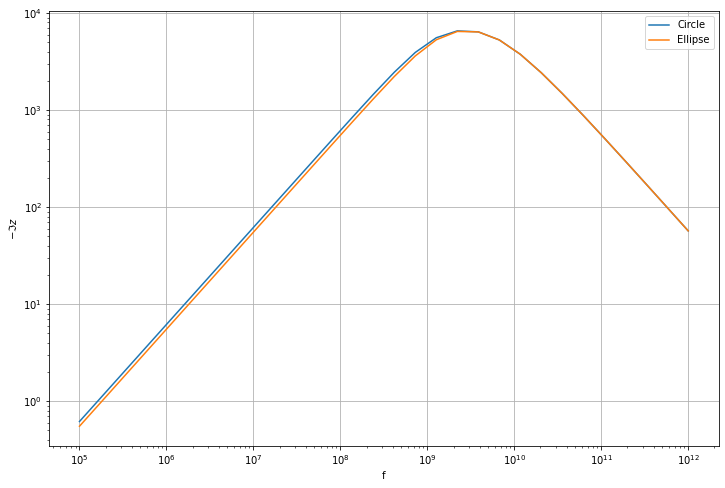

In [8]:
pylab.plot(circle_data_monopole_pec[:,0], -circle_data_monopole_pec[:,2])
pylab.plot(ellipse_data_monopole_pec[:,0], -ellipse_data_monopole_pec[:,2])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f")
pylab.ylabel(r"$-\Im{z}$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

### Monopole SIBC

In [9]:
%%time

circle_data_monopole_sibc = circle_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[steel])
ellipse_data_monopole_sibc = ellipse_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.MONOPOLE, sibc=[steel])

CPU times: user 2min 55s, sys: 4.91 s, total: 3min
Wall time: 3min


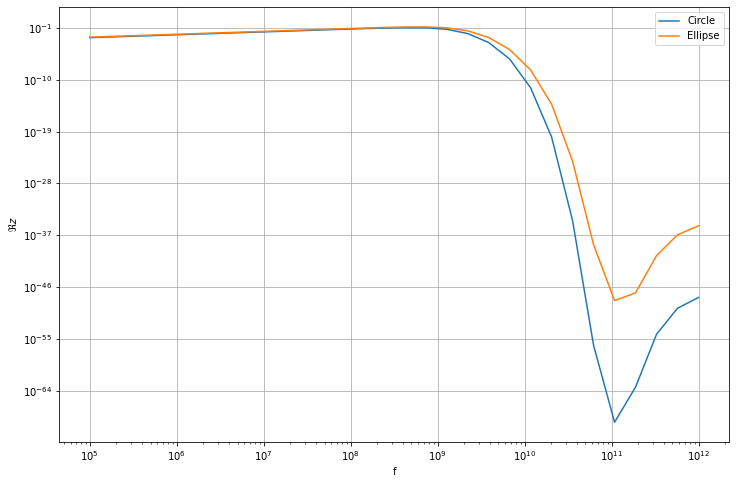

In [10]:
pylab.plot(circle_data_monopole_sibc[:,0], circle_data_monopole_sibc[:,1])
pylab.plot(ellipse_data_monopole_sibc[:,0], ellipse_data_monopole_sibc[:,1])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f")
pylab.ylabel(r"$\Re{z}$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

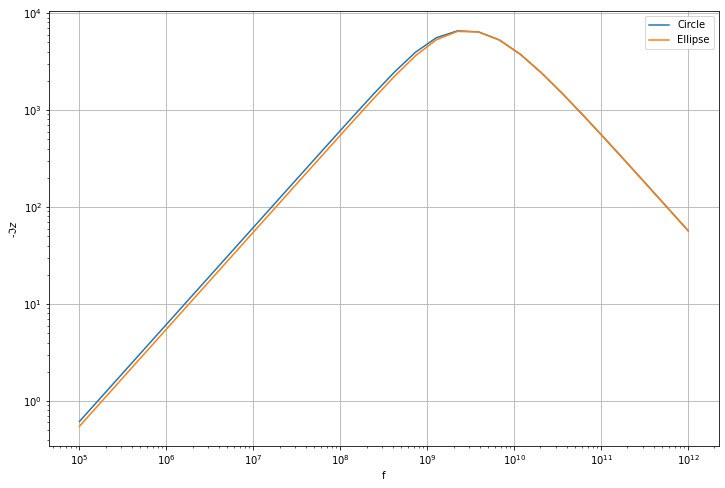

In [11]:
pylab.plot(circle_data_monopole_sibc[:,0], -circle_data_monopole_sibc[:,2])
pylab.plot(ellipse_data_monopole_sibc[:,0], -ellipse_data_monopole_sibc[:,2])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f")
pylab.ylabel(r"-$\Im{z}$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

### Dipole PEC

In [12]:
%%time

circle_data_dipole_pec = circle_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.DIPOLE)
ellipse_data_dipole_pec = ellipse_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.DIPOLE)

CPU times: user 2min 48s, sys: 4.72 s, total: 2min 53s
Wall time: 2min 53s


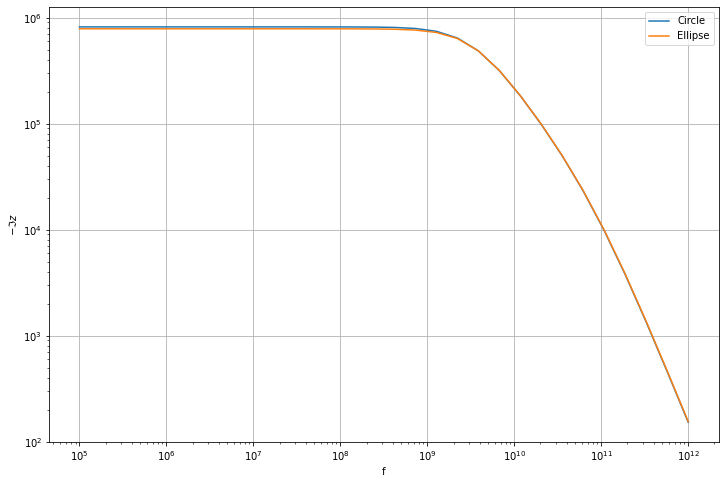

In [13]:
pylab.plot(circle_data_dipole_pec[:,0], -circle_data_dipole_pec[:,2])
pylab.plot(ellipse_data_dipole_pec[:,0], -ellipse_data_dipole_pec[:,2])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f")
pylab.ylabel(r"$-\Im{z}$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

### Dipole SIBC

In [14]:
%%time

circle_data_dipole_sibc = circle_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.DIPOLE, sibc=[steel])
ellipse_data_dipole_sibc = ellipse_solution.get_z(np.logspace(5, 12, num=30), beta=0.5, source_function=bi2d.SourceFunction.DIPOLE, sibc=[steel])

CPU times: user 2min 58s, sys: 4.99 s, total: 3min 3s
Wall time: 3min 3s


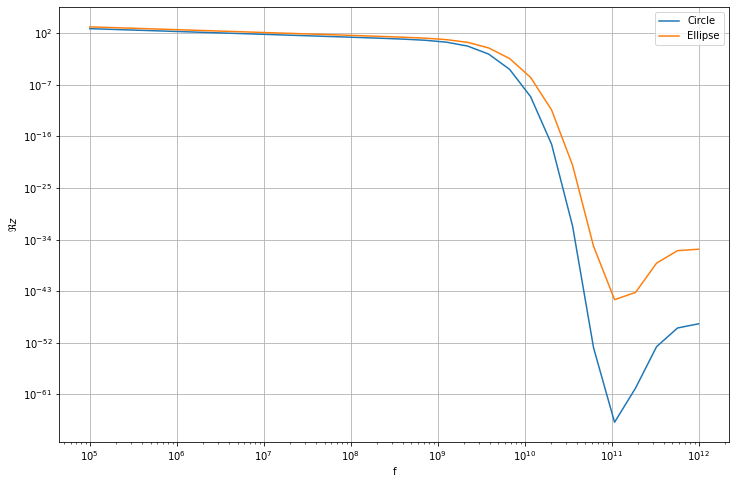

In [15]:
pylab.plot(circle_data_dipole_sibc[:,0], circle_data_dipole_sibc[:,1])
pylab.plot(ellipse_data_dipole_sibc[:,0], ellipse_data_dipole_sibc[:,1])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f")
pylab.ylabel(r"$\Re{z}$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()

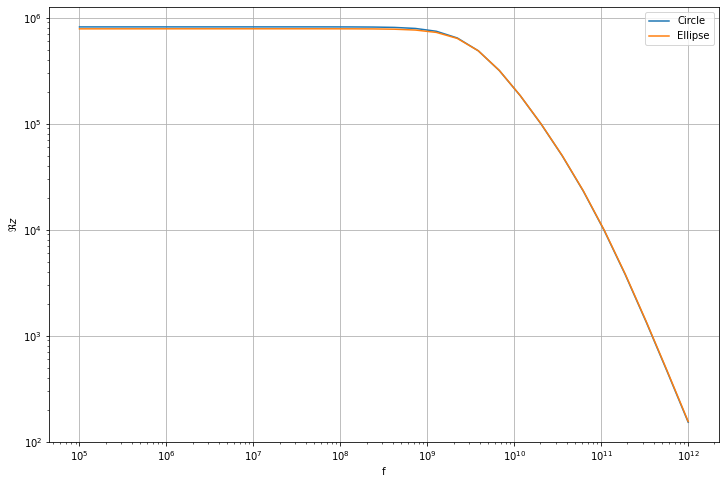

In [16]:
pylab.plot(circle_data_dipole_sibc[:,0], -circle_data_dipole_sibc[:,2])
pylab.plot(ellipse_data_dipole_sibc[:,0], -ellipse_data_dipole_sibc[:,2])
pylab.yscale("log")
pylab.xscale("log")
pylab.xlabel("f")
pylab.ylabel(r"$\Re{z}$")
pylab.grid()
pylab.legend([r"Circle", r"Ellipse"])
pylab.show()